In [95]:
import xgi
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

# Edge-adding Function

In [2]:
def add_hyperedge(H, labels, p, q, num_ext, num_new):
    e_prime = [] # create an empty new edge called e_prime

    ## randomly select an existing hyperedge e to start with
    e_num = random.randint(0, H.num_edges - 1)
    e = H.edges.members()[e_num]
    e_size = H.edges.size.asdict().get(e_num)

    ## randomly select a node u from e
    u_num = random.randint(0, e_size - 1)
    u = list(e)[u_num]
    u_label = H.nodes.attrs.asdict().get(u).get("label")
    e_prime.append(u)

    ## add other nodes from e to e_prime
    # add node with same label as u with prob p
    # add node with different label from u with prob q
    for node in e:
        if H.nodes.attrs.asdict().get(node).get("label") == u_label:
            prob = p
        else:
            prob = q
        if random.random() < prob:
            e_prime.append(node)
    
    ## add exterior nodes
    for i in range(0, num_ext):
        if len(list(H.nodes - e)) > 0:
            exterior_node = random.sample(list(H.nodes - e), 1)[0] # randomly sample a node from outside the existing hyperedge
            e_prime.append(exterior_node)
        # else:
        #     print("No remaining exterior nodes, one failed to add")

    ## add new nodes
    for i in range(0, num_new):
        new_node = len(H.nodes) + 1
        H.add_node(new_node)
        new_label = np.random.choice([labels[0], labels[1]])
        H.set_node_attributes({new_node : new_label}, name = "label")
        e_prime.append(new_node)

    H.add_edge(e_prime)

# Helper Functions

In [78]:
def lik_given_e_u_eprime(H, e, u, e_prime, p, q):
    edge_set = list(H.edges)[0:e_prime]
    vertex_set = list(H.nodes)[0:e_prime + 1]
    alpha_u = 0
    e_u = 0
    alpha_r = 0
    e_r = 0
    u_label = H.nodes.attrs.asdict().get(u).get("label")
    for node in H.edges.members(e):
        if H.nodes.attrs.asdict().get(node).get("label") == u_label:
            e_u += 1
            if node in H.edges.members(e_prime):
                alpha_u += 1
        else:
            e_r += 1
            if node in H.edges.members(e_prime):
                alpha_r += 1
    if (len(vertex_set) - len(H.edges.members(e))) > 0:
        term = (len(vertex_set) - len(H.edges.members(e)))
    else:
        term = 1
    prob = (1 / len(edge_set)) * (1 / len(H.edges.members(e))) * (p ** (alpha_u - 1)) * ((1 - p) ** (e_u - alpha_u)) * (q ** alpha_r) * ((1 - q) ** (e_r - alpha_r)) * (1 / term) * 0.5
    return prob

In [79]:
def lik_given_e_eprime(H, e, e_prime, p, q):
    prob = 0
    for u in H.edges.members(e):
        prob += lik_given_e_u_eprime(H, e, u, e_prime, p, q)
    return prob

In [80]:
def lik_given_eprime(H, eprime, p, q):
    prob = 0
    for e in list(H.edges)[0:eprime]:
        prob += lik_given_e_eprime(H, e, eprime, p, q)
    return prob

In [81]:
def lik_given_H(H, p, q):
    eprime_seq = list(H.edges)[1:]
    prob = 1
    for eprime in eprime_seq:
        lik = lik_given_eprime(H, eprime, p, q)
        prob = prob * lik
    return prob

# Likelihood Plot

In [151]:
p = 0.7
q = 0.4
H= xgi.Hypergraph([[0,1]]) # create hypergraph
H.set_node_attributes({0 : 0, 1 : 1}, name = "label") # set node labels
for i in range(0, 100):
    add_hyperedge(H, [0,1], p, q, 1, 1)

In [152]:
p_q_lik = []
for p in np.arange(0.1, 1.1, 0.1):
    for q in np.arange(0.1, 1.1, 0.1):
        lik = lik_given_H(H, p, q)
        p_q_lik.append([p, q, lik])

<function matplotlib.pyplot.show(close=None, block=None)>

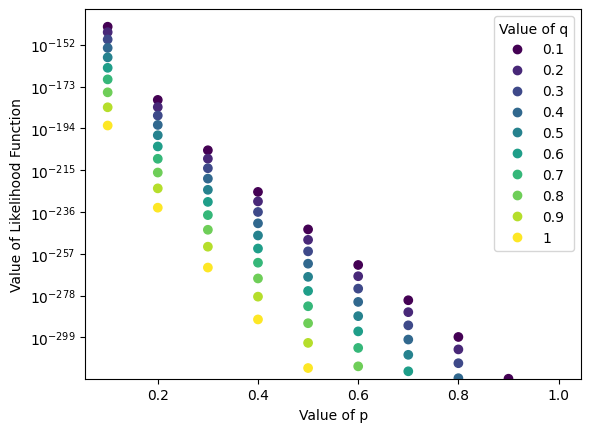

In [159]:
df = np.array(p_q_lik)
fig, ax = plt.subplots()
scatter = plt.scatter(x = df[:,0], y = df[:,2], c = df[:,1])
handles, labels = scatter.legend_elements()
plt.yscale("log")
plt.xlabel("Value of p")
plt.ylabel("Value of Likelihood Function")
legend = ax.legend(handles = handles, labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"], title="Value of q")
plt.show